# Use and Manage Public Data in Research Projects -- Example 2

Tian Lou \
July, 2022

## Table of Contents
<a id = "toc"> </a>

- [FRED API](#fred_api)
- [Get Multiple Series IDs](#multp_ids)
- [Get State Level Weekly Initial Claims](#initial_claim)
- [Get State Level Resident Population](#state_pop)
- [Visualize Your Data](#viz)

## FRED API
<a id = "fred_api"> </a>

[Go back to Table of Content](#toc)

In this notebook, we will retrieve March - April 2020 state level weekly UI claims data and state level resident population. We will also create two interactive maps to see which states had the most initial claims and the most initial claims per 1000 people at the start of the pandemic. We can get these data from FRED, i.e., Federal Reserve Economic Data. FRED includes economic data from various data sources, such as BLS, U.S. census, etc. We can conveniently obtain different data by using FRED API. 

For more information about FRED and FRED API, see: https://fred.stlouisfed.org/docs/api/fred/

**pandas_datareader** is the library we will use to get access to FRED and convert the data to pandas DataFrames. For more information, see: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [ ]:
#Load libraries
import pandas as pd
import datetime as dt

#For accessing API
import pandas_datareader as pdr
import requests

#Visualization
import plotly.express as px

Similar to what we did in the first example, before using the API, wee need to:
1. **Create an account and request a FRED API key**: https://fred.stlouisfed.org/docs/api/api_key.html
2. **Identify the series ids of the data.**

<div class="alert alert-danger">Here is an example of the series ids for Ohio weekly initial claims. <strong>OHICLAIMS</strong> is the series id. <br></div> 

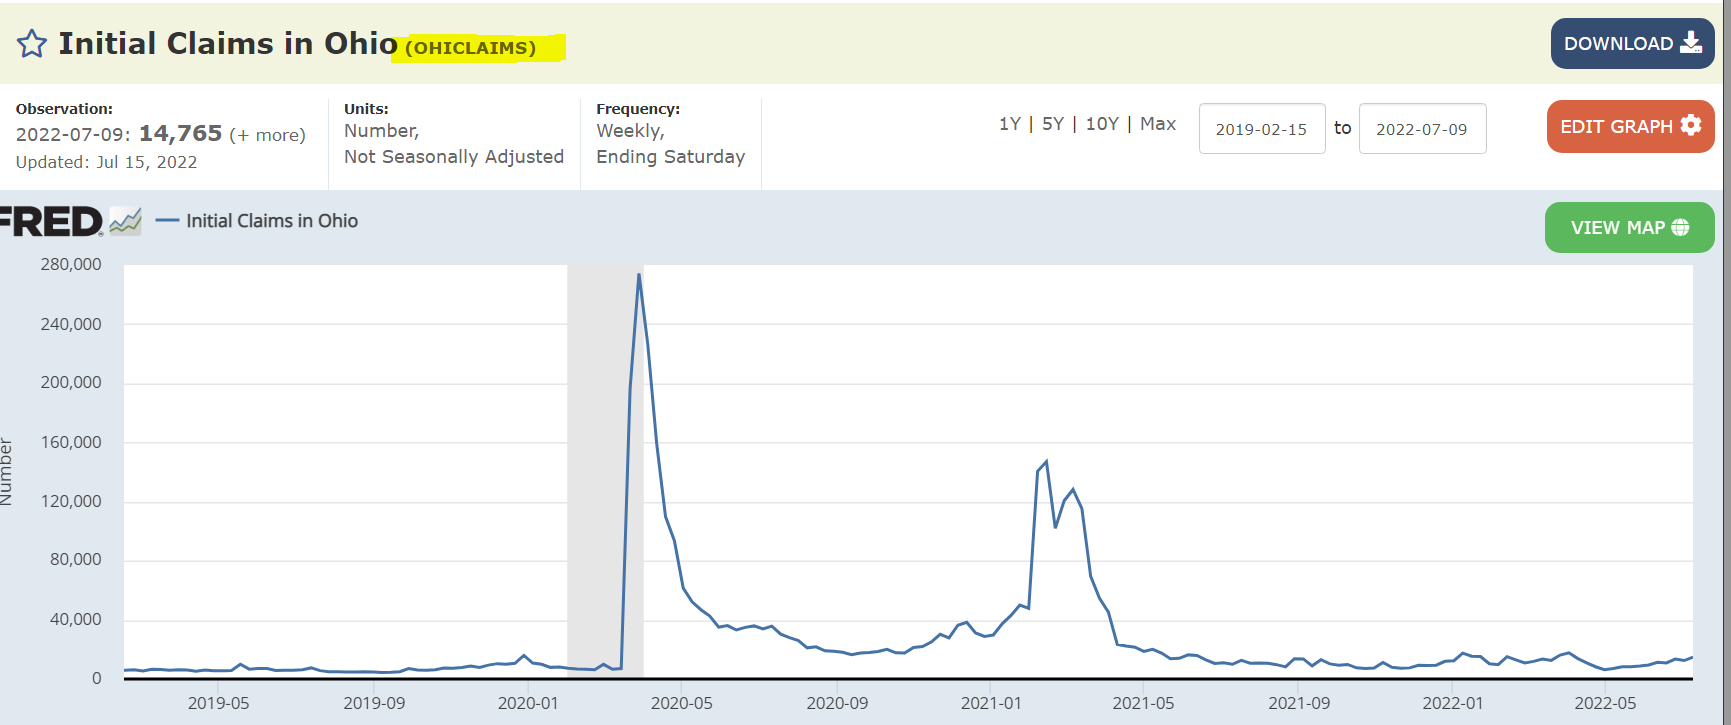

## Get Multiple Series IDs
<a id = "multp_ids"> </a>

[Go back to Table of Content](#toc)

Our goal is to get multiple states' data. Note that the first two letters of the series id "**OHICLAIMS**" are the abbreviation of Ohio. Similar to example 1, we can generate a list of state abbreviations and loop through the list.

In this notebook, we will see an alternative way of getting multiple series ids from FRED. The method comes from this blog post: https://towardsdev.com/fred-api-get-us-economic-data-using-python-e51ac8e7b1cc

In [ ]:
#Create two functions to get multiple series ids

#The first function passes a single series id into FRED’s API to get all series for the same geography type
def get_fred_series_data(api_key, series):
    # url
    url = "https://api.stlouisfed.org/geofred/series/data?series_id={0}&api_key={1}&file_type=json".format(series, api_key)
    # response
    response = requests.request("GET", url)
    return response

#The second function transforms the dataset from json response to a pandas dataframe
def transform_series_response(response):
    latest_date = list(response.json()['meta']['data'].keys())[0]
    return pd.DataFrame(response.json()['meta']['data'][latest_date])

In [ ]:
#Get series ids for each state
response = get_fred_series_data('YOUR_FRED_KEY', 'OHICLAIMS')

# transform response into a dataframe
ids_df = transform_series_response(response)

#See the first five rows of the ids
ids_df.head()

You don't need to worry too much about the details of the functions. You just need to run that code cell and you can use the two functions. In function `get_fred_series_data`, the first value is your FRED API key and the second value is one of the data series ids. This function returns a JSON response. Then we use the function `transform_series_response` to transform the data to a DataFrame.

## Get State Level Weekly Initial Claims
<a id = "initial_claim"> </a>

[Go back to Table of Content](#toc)

In [ ]:
#Get the series ids to a list
ids_list = ids_df['series_id'].tolist()

#See the first five ids
ids_list[:5]

In [ ]:
#Get March-April 2020 state level weekly initial claims
initial_claim_df = pdr.DataReader(ids_list, 'fred', '2020-03-01', '2020-04-30').reset_index()

#Check the first five rows of the data
initial_claim_df.head()

In the above code, we use `pdr.DataReader` function to get all the state level weekly initial claims between March and April 2020 from FRED API. Inside of this function, `ids_list` is the list of data series ids we get in the previous step. `fred` specifies where we want to retrieve the data. Recall that `Pandas_DataReader` can pull data from various sources. The next two variables are the starting date and the ending date of the data you want to get.

Note that the data is in wide format. In order to create visualizations later, we will reshape it to long format and add a column for state abbreviations.

In [ ]:
#Reshape data from wide to long format
initial_claim_df = pd.melt(initial_claim_df, 
                           id_vars = ['DATE'], 
                           value_vars = ids_list, 
                           var_name = 'Series_id', 
                           value_name = 'Initial Claim')

#Generate a new column for state abbrevations
initial_claim_df['State'] = initial_claim_df.apply(lambda x:x['Series_id'][:2], axis = 1)

#Check the first five rows
initial_claim_df.head()

## Get State Level Resident Population
<a id = "state_pop"> </a>

[Go back to Table of Content](#toc)

We can use the same process to get 2020 resident population in each state. Then we merge it with the initial claims DataFrame and calculate initial claims per 1000 people during each week.

In [ ]:
#Get series ids for population
response = get_fred_series_data('YOUR_FRED_KEY', 'OHPOP')

# transform response into a dataframe
pop_ids_df = transform_series_response(response)

#Get the series ids to a list
pop_ids_list = pop_ids_df['series_id'].tolist()

#See the first five ids
pop_ids_list[:5]

In [ ]:
#Get 2020 state level population
pop_df = pdr.DataReader(pop_ids_list, 'fred', '2020-01-01', '2020-12-31').reset_index()

#Reshape data from wide to long format
pop_df = pd.melt(pop_df, 
                 id_vars = ['DATE'], 
                 value_vars = pop_ids_list, 
                 var_name = 'Series_id', 
                 value_name = 'Population')

#Generate a new column for state abbrevations
pop_df['State'] = pop_df.apply(lambda x:x['Series_id'][:2], axis = 1)

#Check the first five rows
pop_df.head()

In [ ]:
#Merge population DataFrame with Initial claims DataFrame
combined_df = initial_claim_df.merge(pop_df[['State', 'Population']], on = 'State', how = 'inner')

#Calculate Initial Claim per 1000 People
combined_df['Initial Claim per 1K People'] = combined_df['Initial Claim']/combined_df['Population']

#See the first five rows of the data
combined_df.head()

## Visualize Your Data
<a id = "viz"> </a>

[Go back to Table of Content](#toc)

Code reference: https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e?gi=4bd247910773 \
Plotly Document: https://plotly.com/python/choropleth-maps/

In [ ]:
#Convert the DATE column to string
combined_df['DATE'] = pd.to_datetime(combined_df['DATE']).dt.date.astype(str)

In [ ]:
#Visualize initial claim by state
fig = px.choropleth(combined_df,
                    locations = 'State',
                    locationmode = 'USA-states',
                    scope = 'usa',
                    color = 'Initial Claim',
                    color_continuous_scale = 'Viridis_r',
                    animation_frame = 'DATE')

#Add title
fig.update_layout(
    title_text = 'March-April Weekly Initial Claims by State',
    title_x = 0.45)

fig.show()

In [ ]:
#Visualize Initial Claim per 1K people
fig = px.choropleth(combined_df,
                    locations = 'State',
                    locationmode = 'USA-states',
                    scope = 'usa',
                    color = 'Initial Claim per 1K People',
                    color_continuous_scale = 'Viridis_r',
                    animation_frame = 'DATE')

#Add title
fig.update_layout(
    title_text = 'March-April Weekly Initial Claims per 1K People by State',
    title_x = 0.4)

fig.show()